In [10]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import matplotlib.pyplot as plt


root_dir = "dataset"

# Loop through each folder
for folder_name in os.listdir(root_dir):
  # Construct folder path
  folder_path = os.path.join(root_dir, folder_name)
  
  # Check if it's a directory
  if os.path.isdir(folder_path):
    # Get image paths (assuming all files in folder are images)
    image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
    
    # Limit to 5 images
    image_paths = image_paths[:4]
    
    # Create a figure for this folder
    fig, axes = plt.subplots(1, 4, figsize=(8, 5))
    fig.suptitle(f"Images from folder: {folder_name}")
    
    # Plot images on the figure
    for i, image_path in enumerate(image_paths):
      img = plt.imread(image_path)
      axes.flat[i].imshow(img)
      axes.flat[i].axis('off')  # Hide axes

    # Show the figure
    plt.tight_layout()
    plt.show()

# Close any open figures
plt.close('all')


<b>Canny Edge Detection</b>

In [ ]:
import cv2
%matplotlib inline

def edge_detector(img_path, t_lower = 125, t_upper = 200):
    img = cv2.imread(img_path)  
    edges =  cv2.Canny(img, t_lower, t_upper)
    plt.figure(figsize=(5,3))
    plt.axis('off')
    plt.imshow(edges)
    return None

In [ ]:
crack_image = r'dataset\crack_defective\00001.jpg'
edge_detector(crack_image)

In [ ]:
non_crack_image = r'dataset\crack_non_defective\00001.jpg'
edge_detector(non_crack_image, 150, 200)

<b>Latent Space Analysis</b>

Model

In [1]:
from torchvision.models.resnet import resnet18

base_model = resnet18(pretrained=True)

c:\Users\kalas\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kalas\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
import torch
feature_extractor = torch.nn.Sequential(*list(base_model.children())[:-1])

Dataset

In [5]:
import torchvision.transforms.v2 as transforms

contrast_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5,), (0.5,))
                                         ])

c:\Users\kalas\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [6]:
from torchvision import datasets

data_dir = 'dataset'
dataset = datasets.ImageFolder(data_dir, transform=contrast_transforms)

In [7]:
import torch


train_ratio = 0.80
train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
                                                            dataset,
                                                            [train_size, test_size])

In [8]:
batch_size = 128
valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Latent Cluster Plotting

Starting Feature Extraction
Features Extracted. Performing PCA...
Finished Performing PCA. Onto Plotting


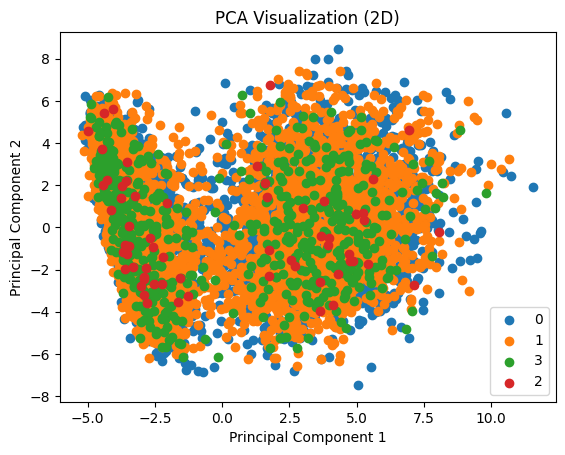

In [9]:
from utility.latent_cluster import clustering

clustering(feature_extractor, val_dataset, valLoader)

Embedding Distance

In [33]:
import torch
from utility.models import ContrastiveNet

PATH = 'weights\ResNet18_Contrastive_10'
saved_model = ContrastiveNet(base_model)
saved_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [34]:
contrastive_feature_extractor = torch.nn.Sequential(*list(saved_model.contnet.children())[:-2])
contrastive_feature_extractor = torch.nn.Sequential(*list(contrastive_feature_extractor[0].children())[:-1])

In [16]:
import torchvision.transforms.v2 as transforms

dist_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5,), (0.5,))
                                         ])

c:\Users\kalas\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [13]:
from utility.latent_dist import *
root_dir = r'C:\Users\kalas\Desktop\MatLLM\dataset'
sampled_images = get_random_images(root_dir)


In [22]:
for first_img in range(0, 4, 1):
    for second_img in range(0, 4, 1):
        print(f"Distance of class {first_img} with {second_img} is"
            ,embedding_dist(contrastive_feature_extractor,
                             sampled_images[first_img][1][0],
                             sampled_images[second_img][1][1],
                             dist_transforms
                             ))


Distance of class 0 with 0 is tensor(0.0495)
Distance of class 0 with 1 is tensor(0.1156)
Distance of class 0 with 2 is tensor(0.1301)
Distance of class 0 with 3 is tensor(0.0910)
Distance of class 1 with 0 is tensor(0.0830)
Distance of class 1 with 1 is tensor(0.0729)
Distance of class 1 with 2 is tensor(0.0861)
Distance of class 1 with 3 is tensor(0.0589)
Distance of class 2 with 0 is tensor(0.1257)
Distance of class 2 with 1 is tensor(0.0680)
Distance of class 2 with 2 is tensor(0.0735)
Distance of class 2 with 3 is tensor(0.0687)
Distance of class 3 with 0 is tensor(0.0874)
Distance of class 3 with 1 is tensor(0.0801)
Distance of class 3 with 2 is tensor(0.0938)
Distance of class 3 with 3 is tensor(0.0650)


In [21]:
for first_img in range(0, 4, 1):
    for second_img in range(0, 4, 1):
        print(f"Distance of class {first_img} with {second_img} is"
            ,embedding_dist(feature_extractor,
                             sampled_images[first_img][1][0],
                             sampled_images[second_img][1][1],
                             dist_transforms
                             ))

Distance of class 0 with 0 is tensor(0.0495)
Distance of class 0 with 1 is tensor(0.1156)
Distance of class 0 with 2 is tensor(0.1301)
Distance of class 0 with 3 is tensor(0.0910)
Distance of class 1 with 0 is tensor(0.0830)
Distance of class 1 with 1 is tensor(0.0729)
Distance of class 1 with 2 is tensor(0.0861)
Distance of class 1 with 3 is tensor(0.0589)
Distance of class 2 with 0 is tensor(0.1257)
Distance of class 2 with 1 is tensor(0.0680)
Distance of class 2 with 2 is tensor(0.0735)
Distance of class 2 with 3 is tensor(0.0687)
Distance of class 3 with 0 is tensor(0.0874)
Distance of class 3 with 1 is tensor(0.0801)
Distance of class 3 with 2 is tensor(0.0938)
Distance of class 3 with 3 is tensor(0.0650)


In [40]:
wts = torch.load(PATH)